## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import emoji
import re
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm 
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/shihanwu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shihanwu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv('Twitter.csv')
# show the size of data
print(f'The data size is: {len(data)}')
data.head(10)

The data size is: 165822


,tweet_id,created_at,user_id,country_code,state,text
0,1223733379960647680,2020-02-01 22:22:28+00:00,168337989,us,Pennsylvania,Corona virus on the east coast 😩🥺😢
1,1223738940093583363,2020-02-01 22:44:33+00:00,959124408387493888,us,Massachusetts,Chinese ppl donated N95 surgical masks to Red ...
2,1223741301104861184,2020-02-01 22:53:56+00:00,14524060,us,Nevada,So tough for the residents living at ground ze...
3,1223509540051832833,2020-02-01 07:33:00+00:00,1064783459791585280,us,Texas,"In 10 fuvkin days, we'll be fuvkin it up at TH..."
4,1223516402067427329,2020-02-01 08:00:16+00:00,825660362,us,Tennessee,So...Harvard goes real Liberal. Investigate ev...
5,1223692998527127553,2020-02-01 19:42:00+00:00,2214984571,us,Tennessee,#cronavirus #CoronavirusOutbreak #es_f $SPY $D...
6,1223708002873696256,2020-02-01 20:41:37+00:00,2259439728,us,Texas,Soooo if a bad ass virus break out in Mexico s...
7,1223720958755655681,2020-02-01 21:33:06+00:00,959501366841425923,us,Nevada,You guys lysol does kill the corona virus xjzb...
8,1223738865988427776,2020-02-01 22:44:16+00:00,144406914,us,Arizona,The last thing I want to do after traveling fo...
9,1223753434521915394,2020-02-01 23:42:09+00:00,154681804,us,South Carolina,Political war is what's happening with the Cor...


### T1-1 Find the different tweets and users

In [3]:
tweets_num = len(data['text'].unique())
user_num = len(data['user_id'].unique())
print(f'The different tweets number is: ', tweets_num)
print(f'The different user number is: ', user_num)

The different tweets number is:  165716
The different user number is:  89121


### T1-2 Find the top 10 comment user

In [4]:
# calculate the top users
top_user = data['user_id'].value_counts().head(10)

# show the result of top users
print(f'The top 10 users are:\n', top_user)

The top 10 users are:
 16223941      242
35203319      238
38751027      216
1598812760    193
44983352      180
359612102     176
13920982      169
1216916479    145
4548937528    114
1699793220    103
Name: user_id, dtype: int64


### T1-3

Text(0.5, 1.0, 'The total number of tweets posted on each day')

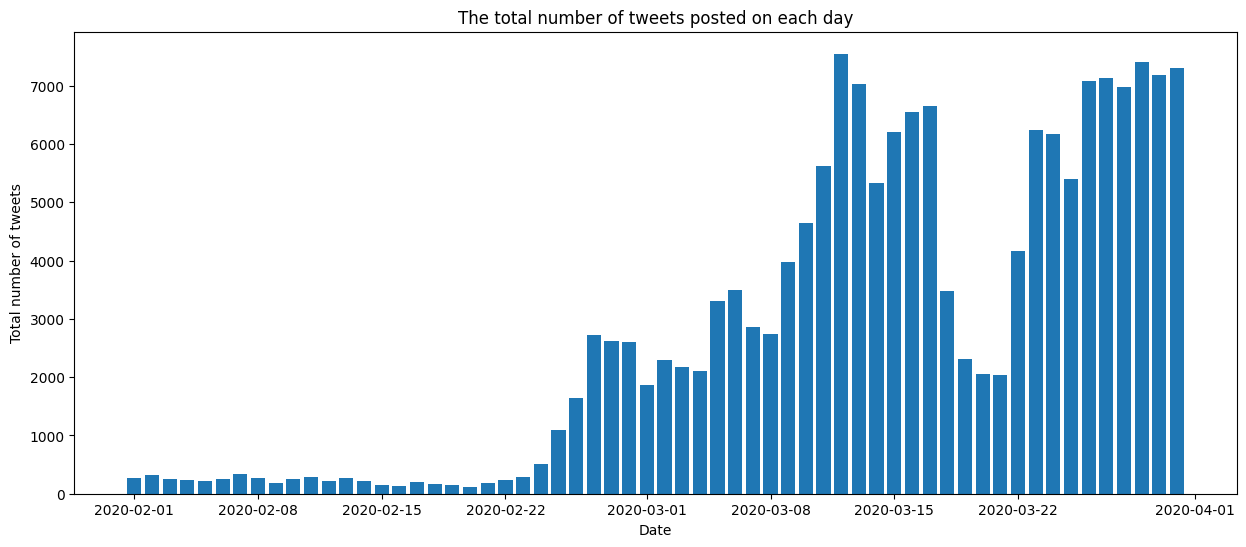

In [5]:
## change the type of dates
data['created_at'] = pd.to_datetime(data['created_at'])
data['created_at'] = data['created_at'].dt.date

# group by dates with number of tweets
data_group = data.groupby('created_at').count()

# plot the number of tweets with dates
plt.rcParams['figure.figsize'] = (15, 6)
plt.bar(data_group.index, data_group['tweet_id'])
plt.xlabel('Date')
plt.ylabel('Total number of tweets')
plt.title('The total number of tweets posted on each day')

## T1-4 Figure to show the number of tweets posted from each state

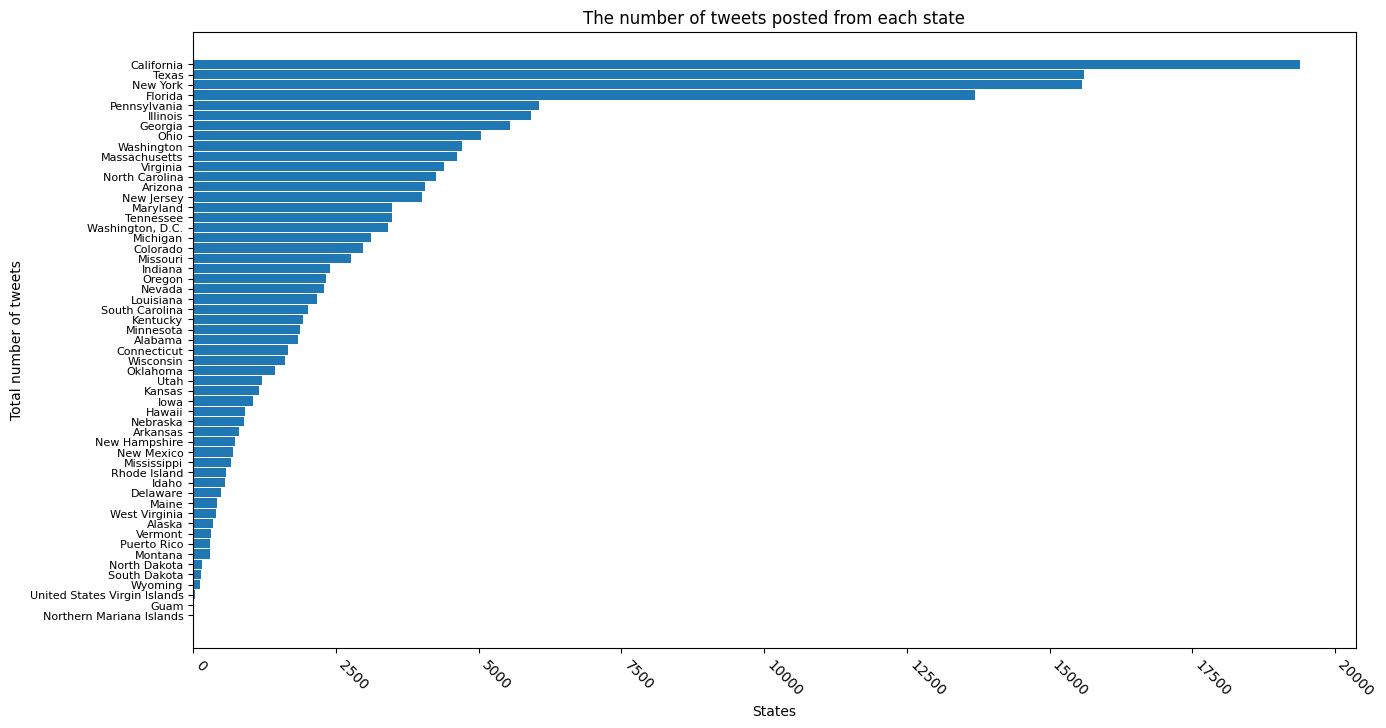

In [6]:
# calculate the number of tweets from each state
tweets_state = data.groupby('state').count()
tweets_state = tweets_state.sort_values(by='tweet_id', ascending=True)

# plt the number of tweets in bar chart with descent order
plt.rcParams['figure.figsize'] = (15, 8)
plt.barh(tweets_state.index, tweets_state['tweet_id'],height=0.9)

plt.xticks(rotation=-45, ha='left')
plt.xlabel('States', fontsize=10)
plt.ylabel('Total number of tweets', fontsize=10)
plt.yticks(fontsize=8)
plt.title('The number of tweets posted from each state', fontsize=12)
plt.show()

Text(0.5, 1.0, 'Number of tweets shown in Geo Map')

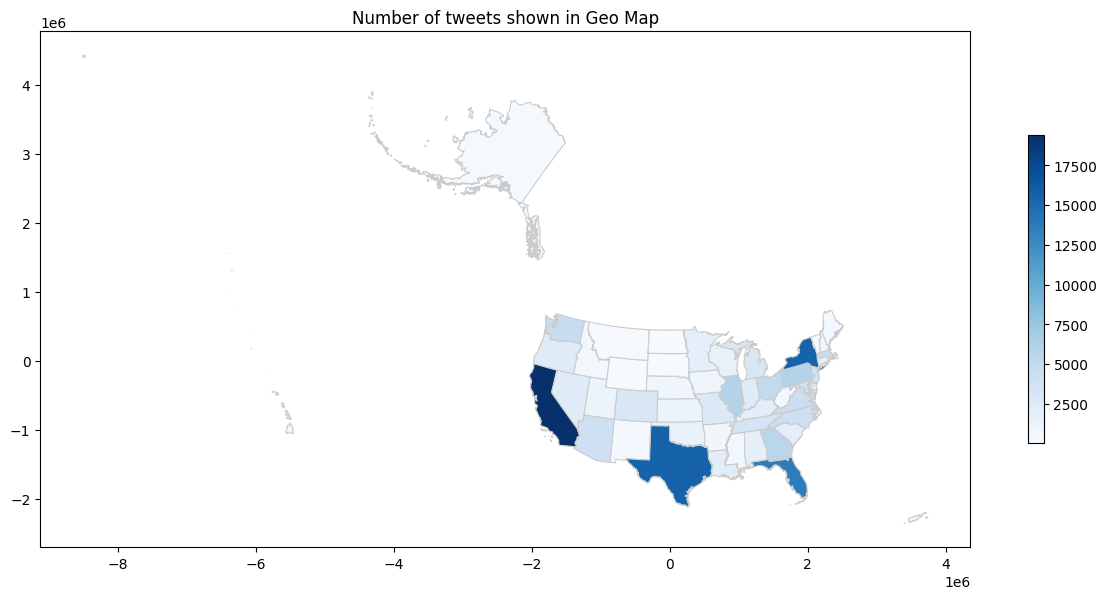

In [7]:
tweet_count = data.groupby('state').count().reset_index()
tweet_count = tweet_count[['state', 'tweet_id']]
tweet_count.columns = ['state', 'tweet_id']
topic_count = tweet_count.sort_values(by='tweet_id', ascending=True)

gdf = gpd.read_file('cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
gdf = gdf.merge(tweet_count, left_on='NAME', right_on='state')

# Create a "copy" of gdf for re-projecting
visframe = gdf.to_crs({'init': 'epsg:2163'})

visframe[~visframe.state.isin(['HI', 'AK'])].plot(column='tweet_id',
                                                      cmap='Blues', linewidth=0.8, 
                                                      edgecolor='0.8', legend=True,
                                                      legend_kwds={'shrink': 0.5, 'aspect': 20})

plt.title('Number of tweets shown in Geo Map')


## T2-1 All preprocessing with raw dataset

In [8]:
## deal with emoji
## give a function to deal with emoji using the library called emoji
def remove_emoji(text):
    return emoji.replace_emoji(text)

## deal with link
def remove_link(text):
    text = re.sub(r"\S*https?:\S*", "", text)
    return text

## deal with special characters
def remove_special_symbol(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

# remove mutiple spaces
def remove_multiple_space(text):
    text = re.sub("\s\s+", " ", text)
    return text

# combine all the prepocessing together 
def pre_processing(data):
    # Add one more step to turn all letters in lower case
    data = data.lower()
    data = remove_emoji(data)
    data = remove_link(data)
    data = remove_special_symbol(data)
    data = remove_multiple_space(data)
    return data

## apply functions in real dataset
data['text'] =data["text"].map(lambda x: pre_processing(x))

In [9]:
data.head(5)

,tweet_id,created_at,user_id,country_code,state,text
0,1223733379960647680,2020-02-01,168337989,us,Pennsylvania,corona virus on the east coast
1,1223738940093583363,2020-02-01,959124408387493888,us,Massachusetts,chinese ppl donated n95 surgical masks to red ...
2,1223741301104861184,2020-02-01,14524060,us,Nevada,so tough for the residents living at ground ze...
3,1223509540051832833,2020-02-01,1064783459791585280,us,Texas,in 10 fuvkin days well be fuvkin it up at the ...
4,1223516402067427329,2020-02-01,825660362,us,Tennessee,soharvard goes real liberal investigate every ...


## T2-2 Apply necessary text mining preprocessing techniques

In [10]:
# Tokenization
def word_token(text):
    tokens = word_tokenize(text)
    return tokens

data['text_tokenize'] = data['text'].apply(word_token)

In [11]:
# remove english stop words
english_stop_words = set(stopwords.words('english'))

def remove_stopword(text):
    filtered_words = [word for word in text if word.lower() not in english_stop_words]
    return filtered_words

data['text_remove_stopword'] = data['text_tokenize'].apply(remove_stopword)

In [12]:
# stemming
def stremming(text):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in text]
    return stemmed_tokens

data['text_stemmed'] = data['text_remove_stopword'].apply(stremming)

In [13]:
data.head(5)

,tweet_id,created_at,user_id,country_code,state,text,text_tokenize,text_remove_stopword,text_stemmed
0,1223733379960647680,2020-02-01,168337989,us,Pennsylvania,corona virus on the east coast,"[corona, virus, on, the, east, coast]","[corona, virus, east, coast]","[corona, viru, east, coast]"
1,1223738940093583363,2020-02-01,959124408387493888,us,Massachusetts,chinese ppl donated n95 surgical masks to red ...,"[chinese, ppl, donated, n95, surgical, masks, ...","[chinese, ppl, donated, n95, surgical, masks, ...","[chines, ppl, donat, n95, surgic, mask, red, c..."
2,1223741301104861184,2020-02-01,14524060,us,Nevada,so tough for the residents living at ground ze...,"[so, tough, for, the, residents, living, at, g...","[tough, residents, living, ground, zero, epide...","[tough, resid, live, ground, zero, epidem, hop..."
3,1223509540051832833,2020-02-01,1064783459791585280,us,Texas,in 10 fuvkin days well be fuvkin it up at the ...,"[in, 10, fuvkin, days, well, be, fuvkin, it, u...","[10, fuvkin, days, well, fuvkin, white, swan, ...","[10, fuvkin, day, well, fuvkin, white, swan, k..."
4,1223516402067427329,2020-02-01,825660362,us,Tennessee,soharvard goes real liberal investigate every ...,"[soharvard, goes, real, liberal, investigate, ...","[soharvard, goes, real, liberal, investigate, ...","[soharvard, goe, real, liber, investig, everi,..."


### T2-3 Plot the word cloud image

In [14]:
# Use the column of text remove stopword for wordcloud
word_counts = Counter()

# calculate the word counts for every words
def word_count(column_data):
    for text in column_data:
        text = [t.lower() for t in text]
        word_counts.update(text)
    return word_counts

# displat the top 10 words
word_counts = word_count(data['text_stemmed'])
top_10_words = word_counts.most_common(10)
for (word, count) in top_10_words:
    print(f'{word}: {count}')

coronaviru: 42880
covid19: 20647
trump: 15247
corona: 14731
quarantin: 10203
peopl: 9530
get: 9042
viru: 8351
day: 8155
like: 7405


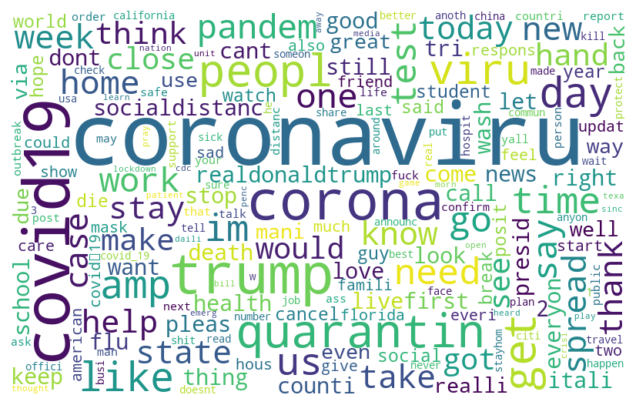

In [15]:
# create the word cloud
def plot_wordcloud(word_counts):
    
    wordcloud = WordCloud(height = 500, width = 800, background_color='white').generate_from_frequencies(word_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_wordcloud(word_counts)

# T3 Topic Modeling

In [16]:
# delete the columns that are unnecessary
data = data.drop(columns=['text', 'text_tokenize', 'text_remove_stopword'])

### Method 1: Document-term matrix

In [17]:
# split the content stored in data to a document and word list
documents = [text for text in data['text_stemmed']]
word = []
for i in documents:
    for j in range(len(i)):
        word.append(i[j])

# create models for dictionary and corpus
id2word = corpora.Dictionary(documents)
corpus = [id2word.doc2bow(text) for text in documents]

### Method 2: TF-IDF Method

In [18]:
# create models corpus with tf-idf method
tf_idf_vectorizer = TfidfVectorizer(min_df=10, max_df=0.8)
tf_idf = tf_idf_vectorizer.fit_transform(word)

feature_names = tf_idf_vectorizer.get_feature_names_out()
corpus_tfidf = gensim.matutils.Sparse2Corpus(tf_idf, documents_columns=False)

### Train the LDA model and calculate evaluation criteria

In [21]:
# Use train the LDA model
def train_topics(corpus, dictionary, documents, topic_list):

    coherence_list = []
    perplexity_list = []

    for i in tqdm(topic_list):  

        lda_ori_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=i, passes=2)

        # calculate the perplexity value
        perplexity = lda_ori_model.log_perplexity(corpus)
        perplexity_list.append(perplexity)

        # calculate the coherence value
        coherence_model_lda = CoherenceModel(model=lda_ori_model, texts=documents, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_list.append(coherence_lda)
    
    return perplexity_list, coherence_list

In [20]:
topic_list = [i for i in range(3,13)]
perplexity_list_ori, coherence_list_ori = train_topics(corpus, id2word, documents, topic_list)

100%|██████████| 10/10 [13:31<00:00, 81.14s/it]


In [22]:
perplexity_list_tfidf, coherence_list_tfidf = train_topics(corpus_tfidf, id2word, documents, topic_list)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [51:12<00:00, 307.28s/it]


# plot to visualize the result for evaluation

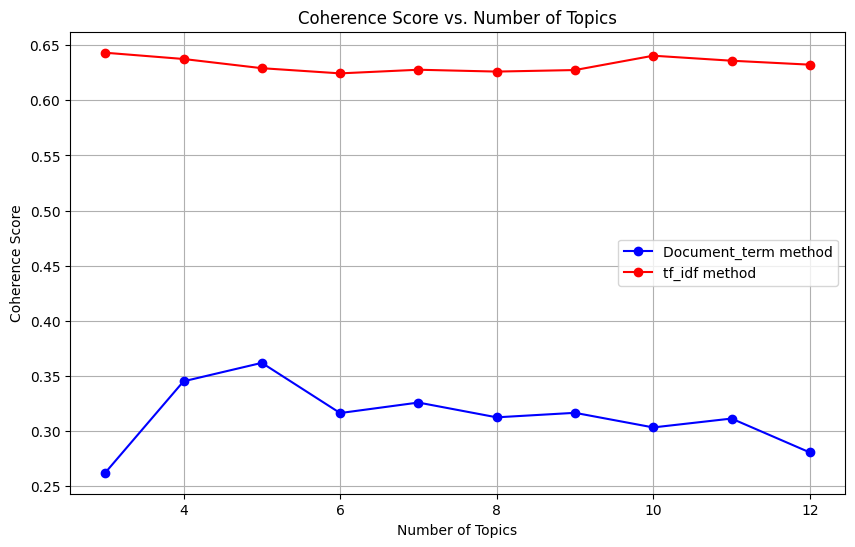

In [23]:
def plot_evaluation(topic_list, data1, data2, title):
    plt.figure(figsize=(10, 6))
    plt.plot(topic_list, data1, marker='o', linestyle='-', color='b', label='Document_term method')
    plt.plot(topic_list, data2, marker='o', linestyle='-', color='r', label='tf_idf method')
    plt.title(f'{title} vs. Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel(f'{title}')
    plt.legend()
    plt.grid(True)
    plt.show()

# plot Coherence and Perplexity
plot_evaluation(topic_list, coherence_list_ori, coherence_list_tfidf, 'Coherence Score')

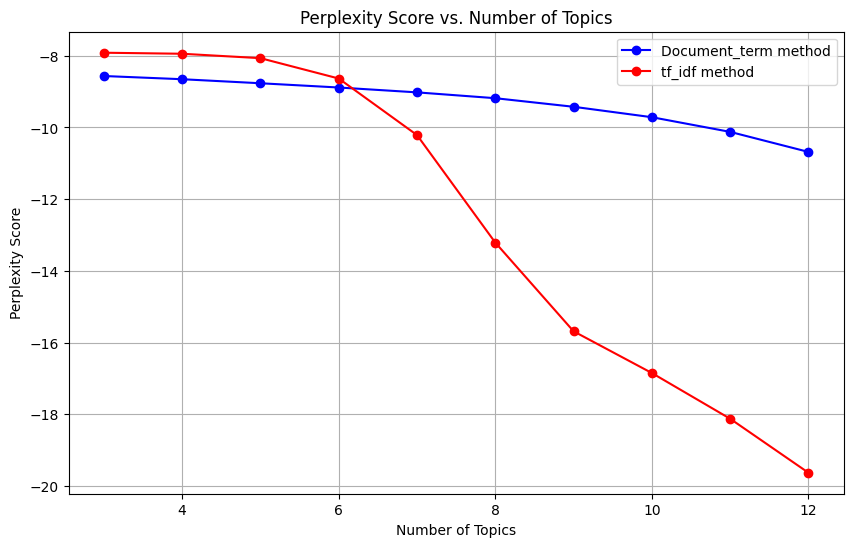

In [25]:
plot_evaluation(topic_list, perplexity_list_ori, perplexity_list_tfidf, 'Perplexity Score')

## Choose the best topic and train one best model

In [26]:
# Choose the best topic number based on coherence and perplexity
best_topic = 10
lda_best_model = LdaModel(corpus=corpus_tfidf, id2word=id2word, num_topics=best_topic, passes=2)

# calculate model coherence for each topic
coherence_model_lda = CoherenceModel(model=lda_best_model, texts=documents, dictionary=id2word, coherence='c_v')
coherence_ldas = coherence_model_lda.get_coherence_per_topic()

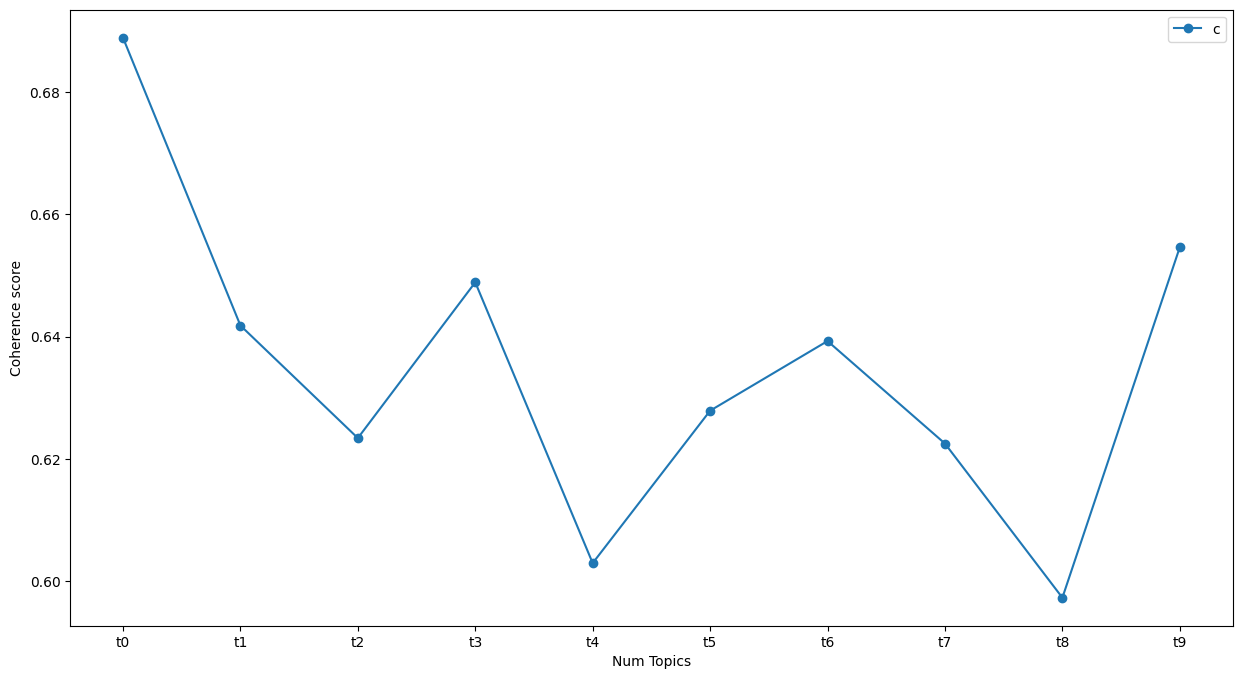

In [27]:
# plot the topic coherence within the best model
topicsname=[]
for i in range(0,best_topic):
    topicsname.append("t{0}".format(i))
plt.plot(topicsname,coherence_ldas,marker='o')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
# print the key words under each topic 
num_words_per_topic = 20 
for index,topic in lda_best_model.print_topics(num_words=num_words_per_topic):
    print(topic)

0.203*"recit" + 0.059*"bologna" + 0.049*"sat" + 0.048*"eftour" + 0.036*"specif" + 0.029*"pa" + 0.029*"virushygien" + 0.026*"dakota" + 0.024*"6549lmartin" + 0.022*"usouthflorida" + 0.020*"childcar" + 0.020*"minut" + 0.020*"delet" + 0.019*"fiscal" + 0.016*"iowacaucas" + 0.014*"stellar" + 0.011*"publish" + 0.011*"kcmo" + 0.010*"statement" + 0.010*"infrastructur"
0.150*"blo" + 0.068*"stood" + 0.065*"whack" + 0.047*"sold" + 0.040*"snapchat" + 0.036*"hysteria" + 0.031*"dearth" + 0.029*"gs5734" + 0.027*"ge" + 0.026*"virul" + 0.021*"thailand" + 0.020*"timecovid19" + 0.016*"liabil" + 0.015*"25" + 0.015*"startl" + 0.014*"dudeklinda" + 0.013*"stricken" + 0.013*"golden" + 0.012*"wallstreet" + 0.012*"putemupcduk"
0.077*"strand" + 0.073*"forecast" + 0.072*"beck" + 0.046*"father" + 0.040*"seed" + 0.027*"chinaviru" + 0.027*"withregram" + 0.027*"29" + 0.025*"realdonaldtrump" + 0.024*"everybodi" + 0.020*"bustl" + 0.019*"youtub" + 0.019*"buddi" + 0.017*"editor" + 0.017*"tempestchas" + 0.016*"notso" + 0.0

In [29]:
# put topic and topic key words into 2 lists respectively
topics = [lda_best_model.get_topic_terms(i, topn=num_words_per_topic) for i in range(best_topic)]
topic_terms = [[id2word[id] for id, _ in tpl] for tpl in topics]

# Assign one topic to each row

In [30]:
## gain topics in each row
document_topics_1 = [lda_best_model.get_document_topics(doc) for doc in corpus]

# the list is to store the topics of each row
document_topics_list_1 = []

for doc_topics in document_topics_1:

    # select the topic that has the highest rank and assign it to the topic of the row
    sorted_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    dominant_topic = sorted_topics[0]
    document_topics_list_1.append(dominant_topic[0])  

# add the topic to the data
data['topic'] = document_topics_list_1

In [31]:
# discover the count for each topic
topic_counts = data['topic'].value_counts()
print(topic_counts)

5    105711
9     10874
0     10229
2      9243
7      8958
4      6047
3      5923
8      4634
6      2667
1      1536
Name: topic, dtype: int64


## Plot the word cloud for each topic

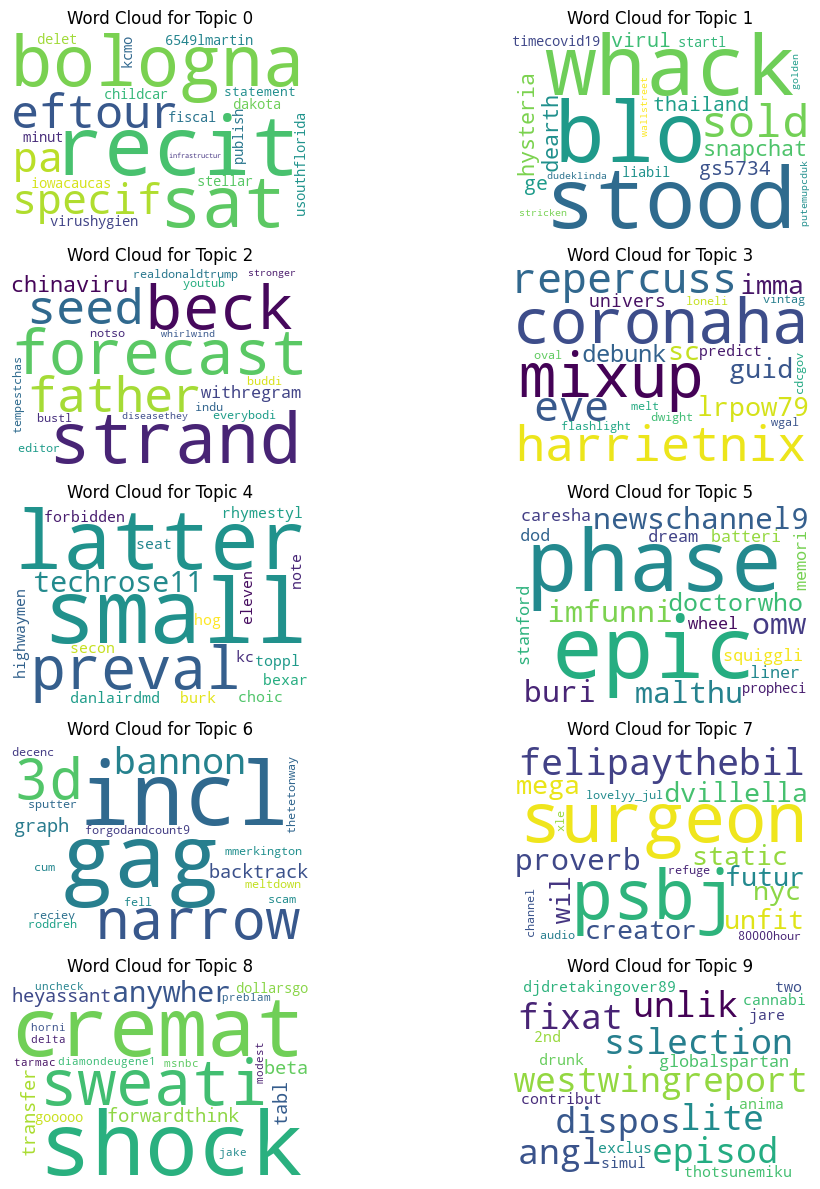

In [32]:
fig, axs = plt.subplots(5, 2, figsize=(12,12))

for i, topic_term_list in enumerate(topic_terms):
    
    # create the wordcloud for differet topics
    topic_text = " ".join(topic_term_list)
    wordcloud = WordCloud(width=300, height=200, background_color='white').generate(topic_text)

    # plot the wordclouds
    row, col = divmod(i, 2)  
    ax = axs[row, col]

    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(f"Word Cloud for Topic {i}")
    ax.axis("off")

fig.tight_layout()
plt.show()


## Time analysis based on different topics

In [33]:
# group the data based on differnt topics and dates, then count the sum for differnt topics
data['created_at'] = pd.to_datetime(data['created_at'])
grouped_data = data.groupby([data['created_at'].dt.date, 'topic']).size().reset_index(name='count')

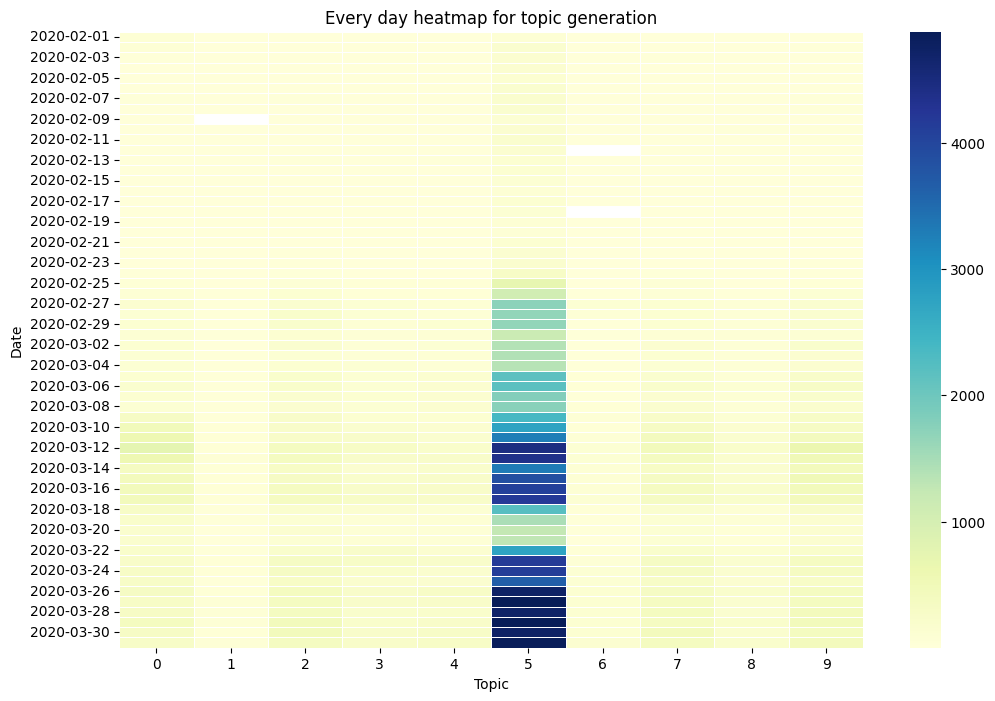

In [34]:
# plot the heat map based on the grouped date and topic
heatmap_data = grouped_data.pivot("created_at", "topic", "count")

# visualiza the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, linewidths=.5)

plt.title("Every day heatmap for topic generation")
plt.xlabel("Topic")
plt.ylabel("Date")
plt.show()


## Show the time series plot with different topics to see their changes

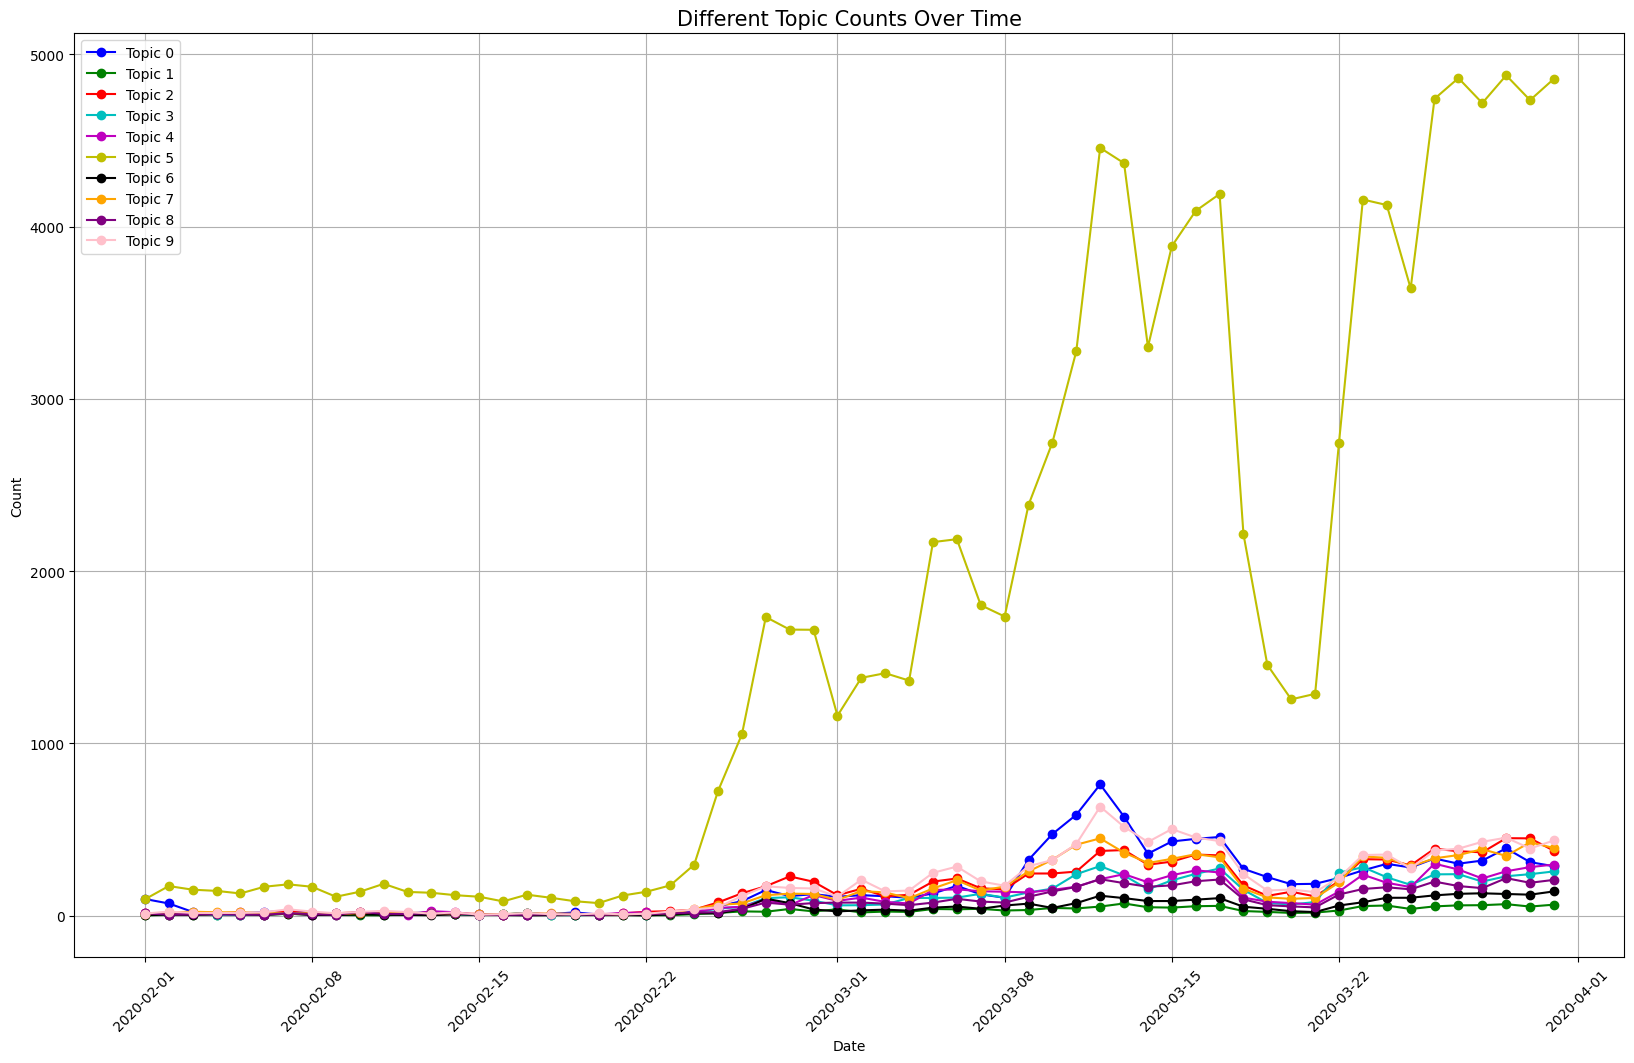

In [35]:
# Assuming you have defined 'best_topic' and 'grouped_data'

fig, ax = plt.subplots(figsize=(20, 12))

# Define a list of colors to use for each topic
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'brown', 'olive']

for i in range(best_topic):
    
    # Create data grouped by different topics and count by date
    topic_data = grouped_data[grouped_data['topic'] == i]
    topic_data['created_at'] = pd.to_datetime(topic_data['created_at'])
    
    # Visualize the data using a different color for each topic
    ax.plot(topic_data['created_at'], topic_data['count'], marker='o', linestyle='-', label=f'Topic {i}', color=colors[i])

ax.set_xlabel('Date')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Count')
ax.set_title('Different Topic Counts Over Time', fontsize=15)
ax.grid(True)

# Add a legend to differentiate the topics
ax.legend()

plt.show()


## Spacial analysis based on different topics

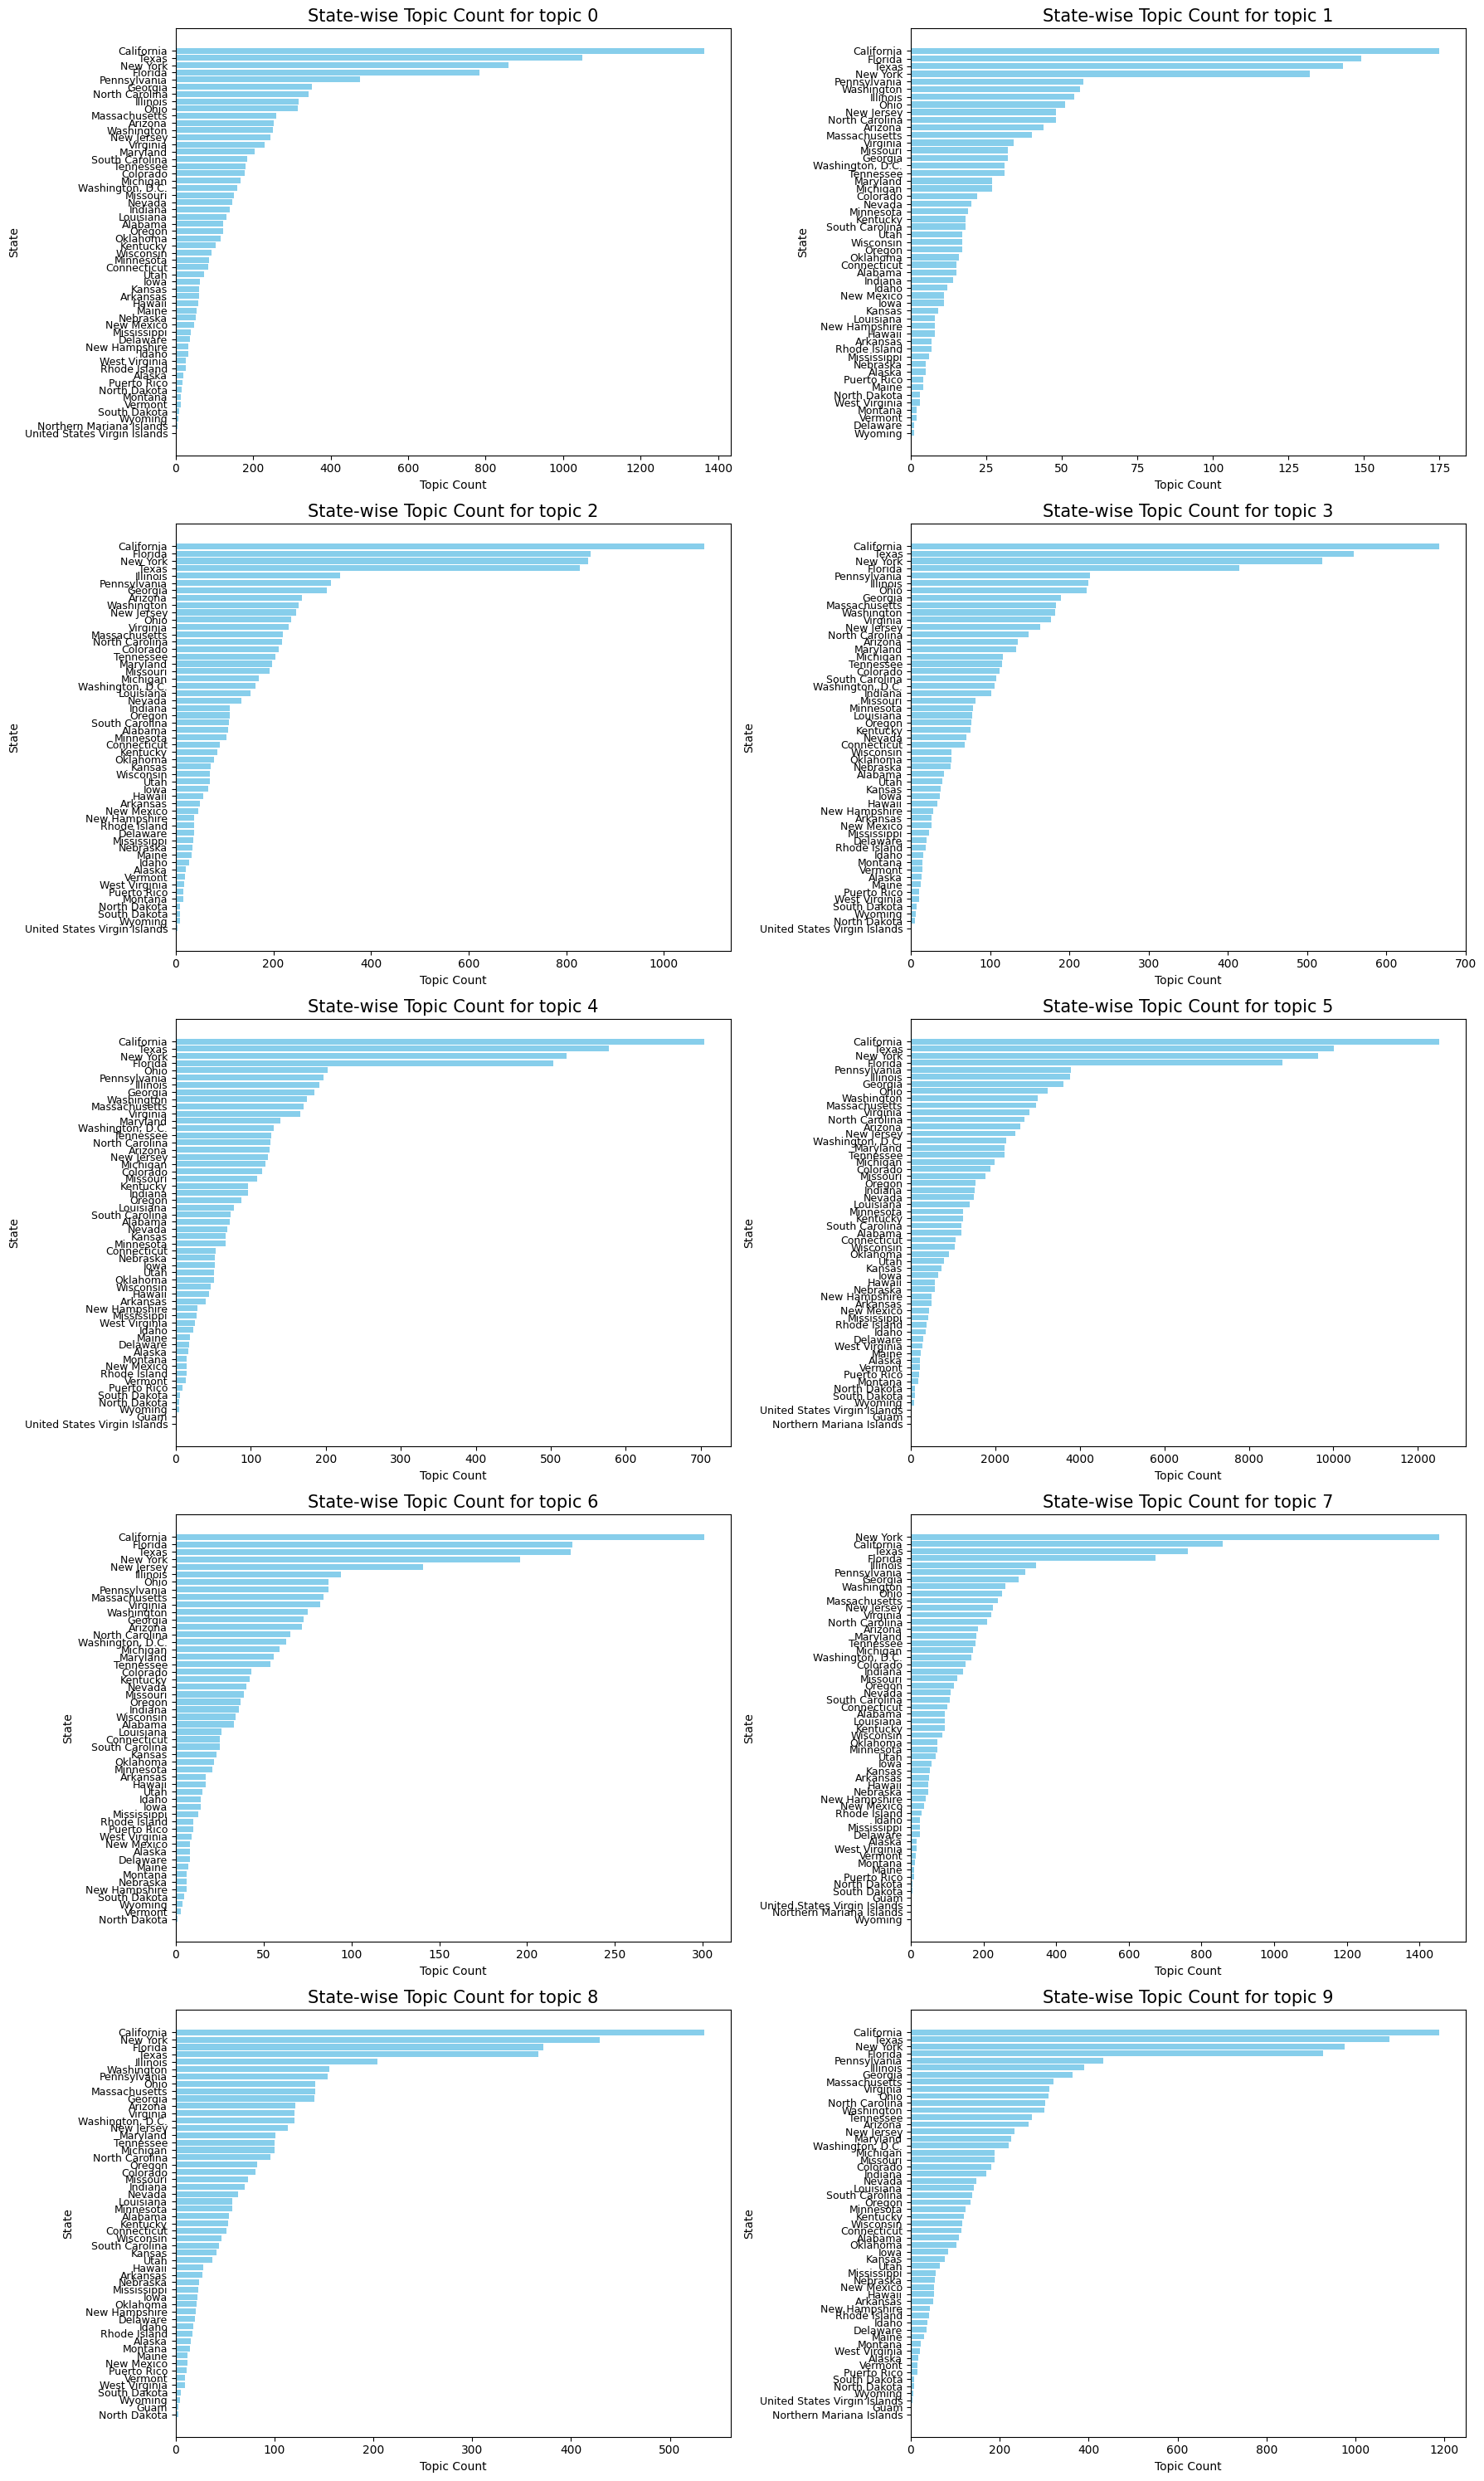

In [36]:
fig, axs = plt.subplots(5, 2, figsize=(18,30))

for i in range(best_topic):

    # calculate the number of tweets in different places
    data_temp = data[data['topic'] == i]
    topic_counts = data_temp.groupby('state')['topic'].count().reset_index()
    topic_counts.columns = ['state', 'topic_count']
    topic_counts = topic_counts.sort_values(by='topic_count', ascending=True)

    # visualize the data
    row, col = divmod(i, 2)  
    ax = axs[row, col]

    ax.barh(topic_counts['state'], topic_counts['topic_count'], color='skyblue')
    ax.set_xlabel('Topic Count')
    ax.set_ylabel('State')
    ax.tick_params(axis='y', labelsize=9)
    ax.set_title(f'State-wise Topic Count for topic {i}', fontsize=15)

plt.tight_layout() 
plt.show()


## show the number of different topics based on geo map

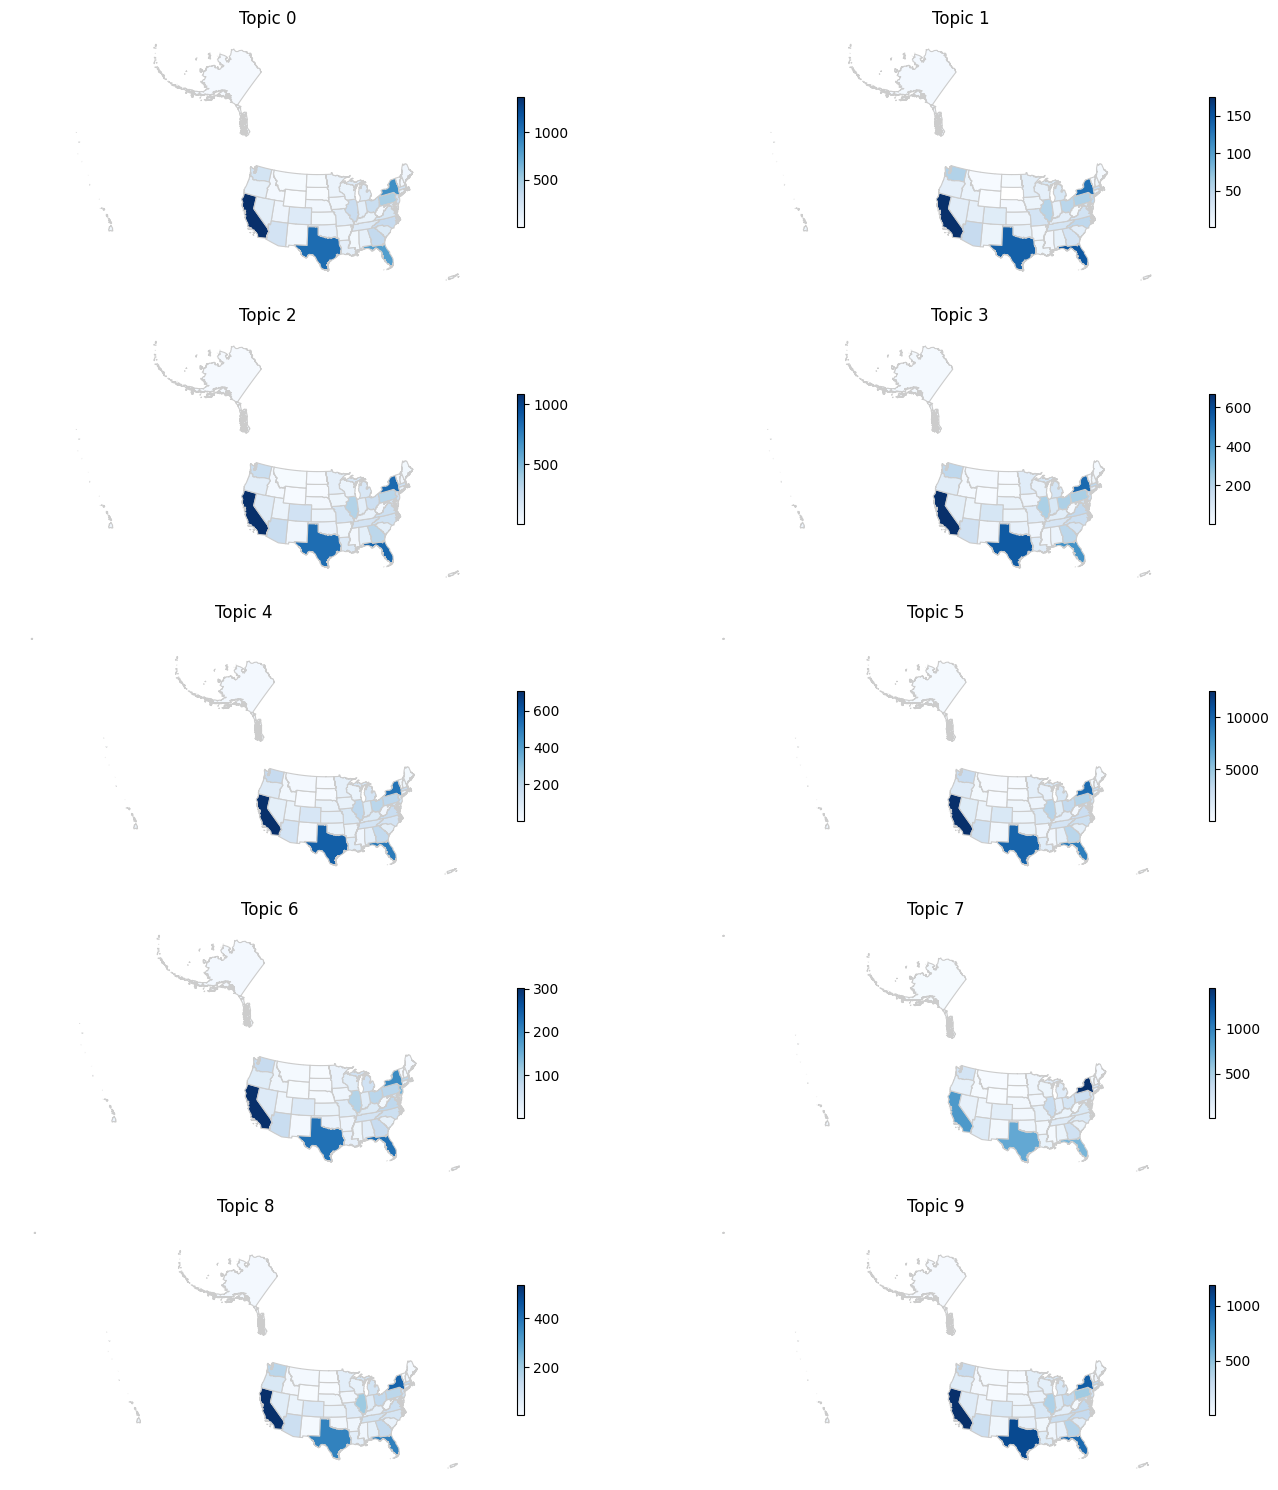

In [37]:
fig, axs = plt.subplots(5, 2, figsize=(15, 15))

for i in range(best_topic):

    # visualiza the data based on their geo map
    data_temp = data[data['topic'] == i]
    topic_counts = data_temp.groupby('state')['topic'].count().reset_index()
    topic_counts.columns = ['state', 'topic_count']
    topic_counts = topic_counts.sort_values(by='topic_count', ascending=True)
    
    gdf = gpd.read_file('cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
    gdf = gdf.merge(topic_counts, left_on='NAME', right_on='state')

    # visualize the data
    visframe = gdf.to_crs({'init': 'epsg:2163'})
    row, col = divmod(i, 2) 
    ax = axs[row, col]
    ax.axis('off')
    ax.set_title(f"Topic {i}", fontsize=12)
    visframe[~visframe.state.isin(['HI', 'AK'])].plot(column='topic_count',
                                                      cmap='Blues', linewidth=0.8,
                                                      ax=ax, edgecolor='0.8', legend=True,
                                                      legend_kwds={'shrink': 0.5, 'aspect': 20})

plt.tight_layout() 
plt.show()


# simple sentiment analysis based on different topics

In [38]:
# calculate the sentiment value of each text
def analyze_sentiment(text):
    data_analyze = TextBlob(text)
    sentiment = data_analyze.sentiment.polarity
    sentiment_judge = judge_sentiment(sentiment)
    return sentiment_judge

# tell the sentiment belongs to positive, nuetral and negative
def judge_sentiment(sentiment):
    if sentiment > 0:
        sentiment_judge = 'positive'
    elif sentiment == 0:
        sentiment_judge = 'nuetral'
    else:
        sentiment_judge = 'negative'
    return sentiment_judge

data['text_string'] = data['text_stemmed'].apply(lambda tokens: ' '.join(tokens))
data['sentimemt'] = data['text_string'].apply(analyze_sentiment)

<function matplotlib.pyplot.show(close=None, block=None)>

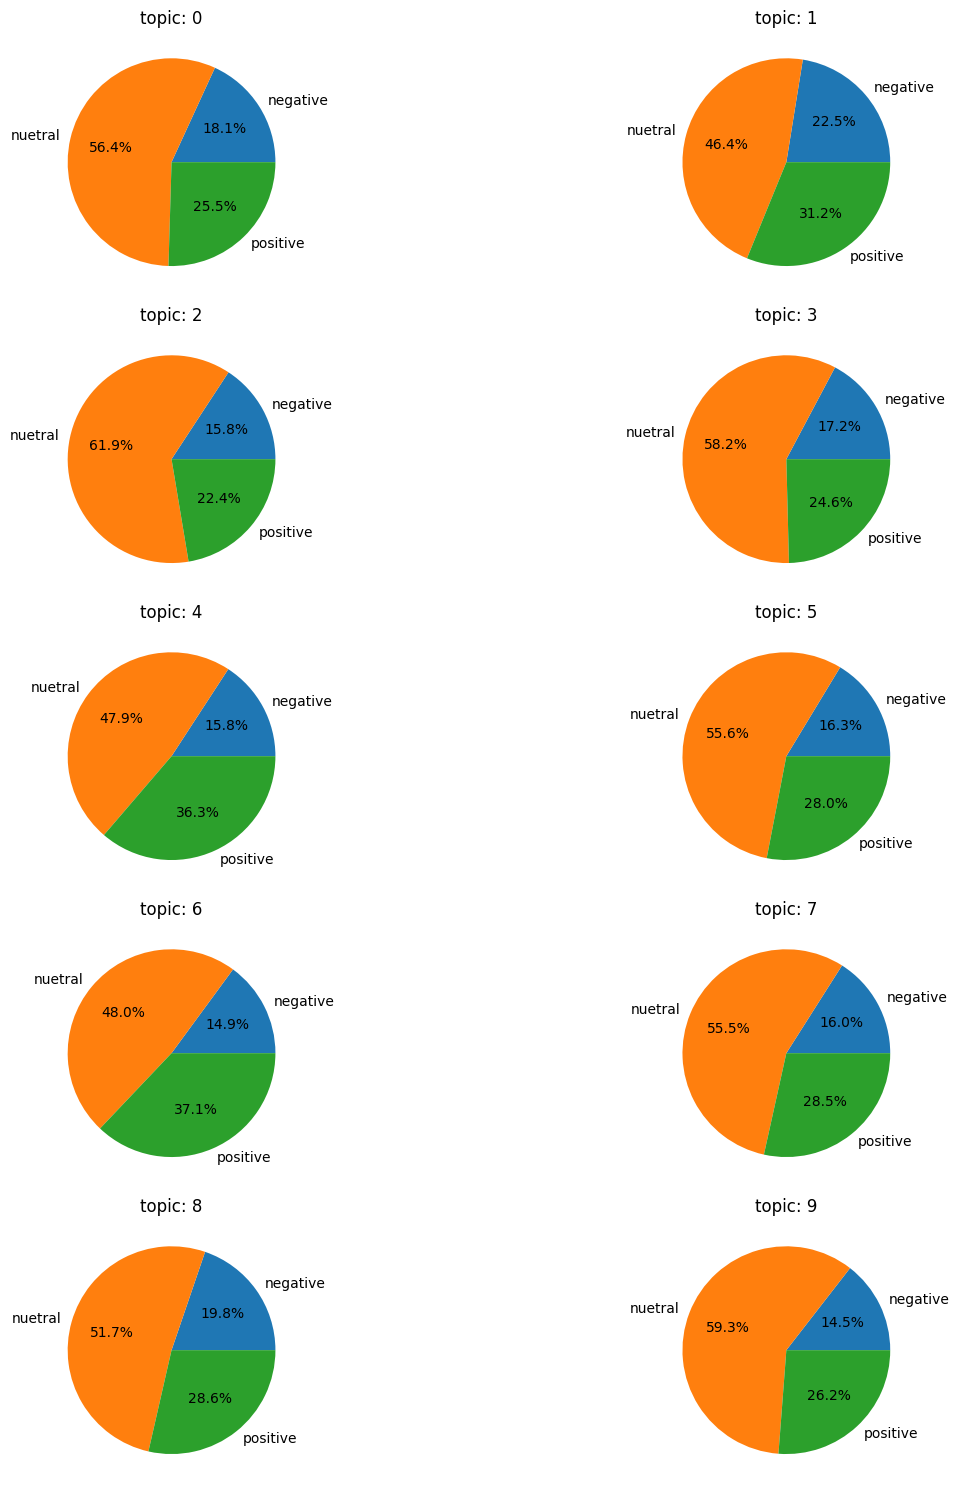

In [39]:
# discover the percentage of each topic
grouped_data = data.groupby(['topic', 'sentimemt']).size().unstack().fillna(0)
topics = grouped_data.index
num_topics = len(topics)
fig, axes = plt.subplots(5, 2, figsize=(15,15))

for i, topic in enumerate(topics):
    topic_data = grouped_data.loc[topic]
    row, col = divmod(i, 2) 
    ax = axes[row, col]
    ax.pie(topic_data, labels=topic_data.index, autopct='%1.1f%%', startangle=0)
    ax.set_title(f'topic: {i}')

plt.tight_layout()
plt.show()